Number of vertices in the datasets/sampled_500.ply dataset: 500
Number of vertices in the datasets/sampled_1000.ply dataset: 1000
Number of vertices in the datasets/sampled_3002.ply dataset: 3002
Number of vertices in the datasets/sampled_4000.ply dataset: 4000
Number of vertices in the datasets/sampled_1501.ply dataset: 1501
Number of vertices in the datasets/sampled_3476.ply dataset: 3476
Number of vertices in the datasets/sampled_2000.ply dataset: 2000

PROCESSING dragon 500 WITH 500 POINTS


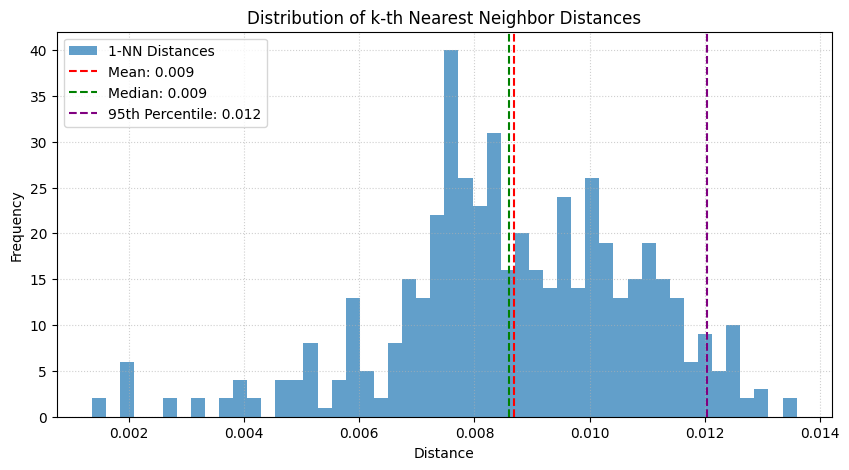

Suggested max_edge_length values:
- mean: 0.0087
- median: 0.0086
- 90th_percentile: 0.0114
- 95th_percentile: 0.0120

PROCESSING dragon 1000 WITH 1000 POINTS


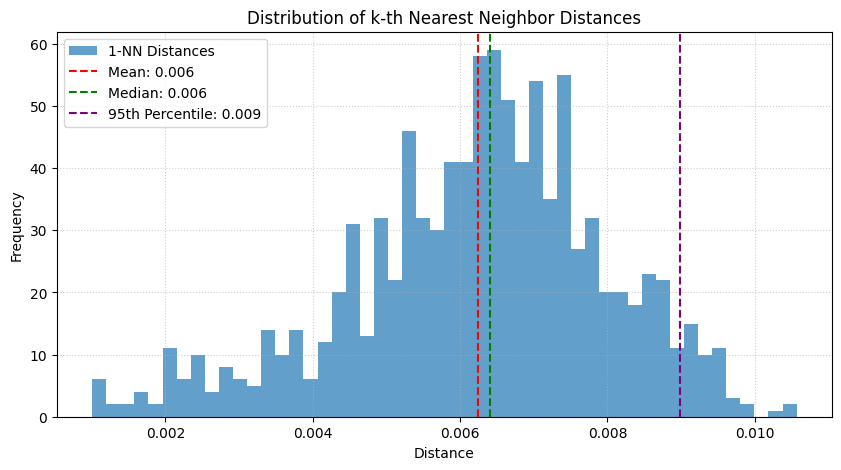

Suggested max_edge_length values:
- mean: 0.0062
- median: 0.0064
- 90th_percentile: 0.0085
- 95th_percentile: 0.0090

PROCESSING dragon 3002 WITH 3002 POINTS


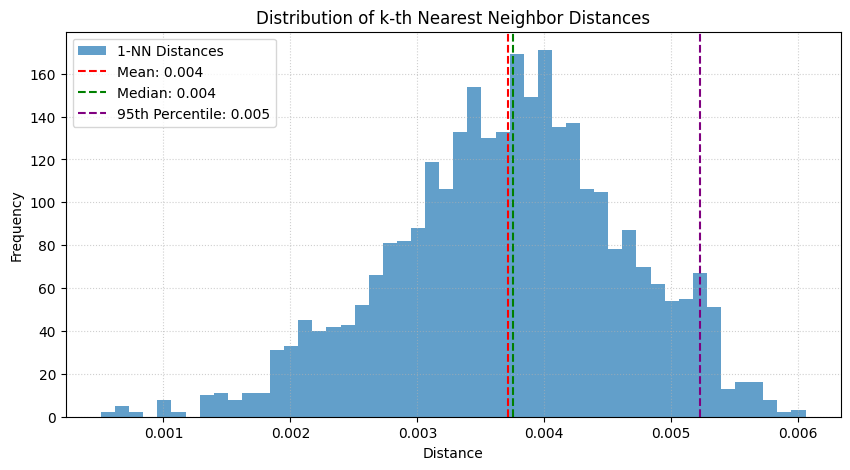

Suggested max_edge_length values:
- mean: 0.0037
- median: 0.0038
- 90th_percentile: 0.0049
- 95th_percentile: 0.0052

PROCESSING dragon 4000 WITH 4000 POINTS


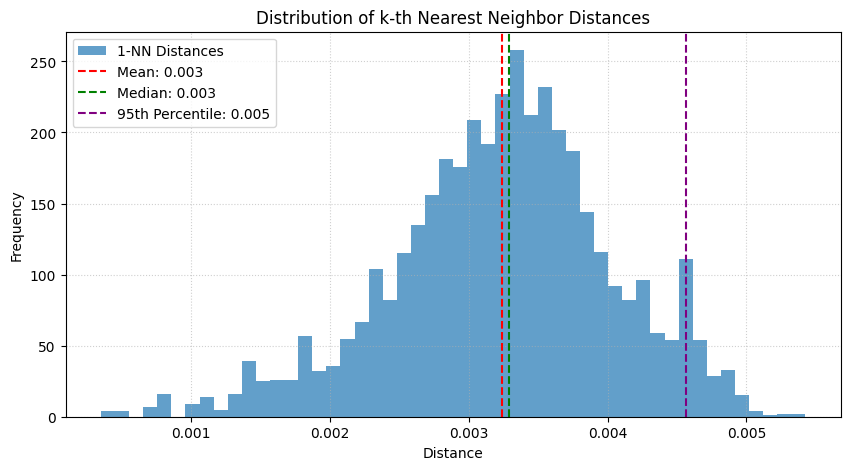

Suggested max_edge_length values:
- mean: 0.0032
- median: 0.0033
- 90th_percentile: 0.0043
- 95th_percentile: 0.0046

PROCESSING dragon 1501 WITH 1501 POINTS


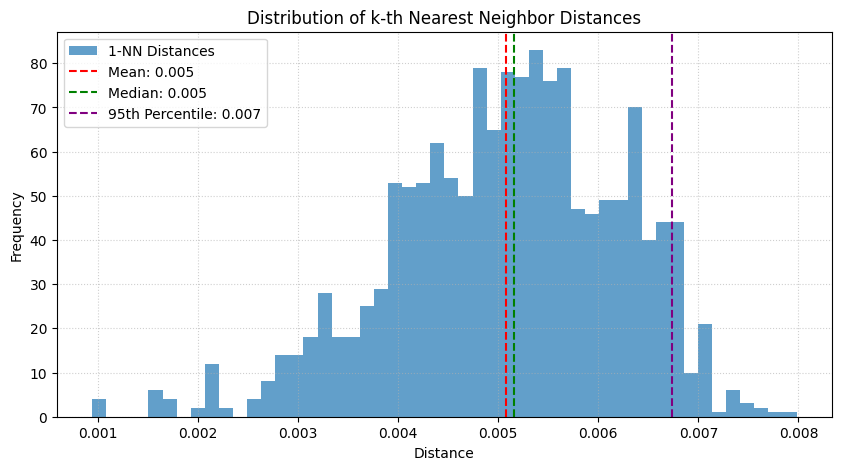

Suggested max_edge_length values:
- mean: 0.0051
- median: 0.0052
- 90th_percentile: 0.0065
- 95th_percentile: 0.0067

PROCESSING dragon 3476 WITH 3476 POINTS


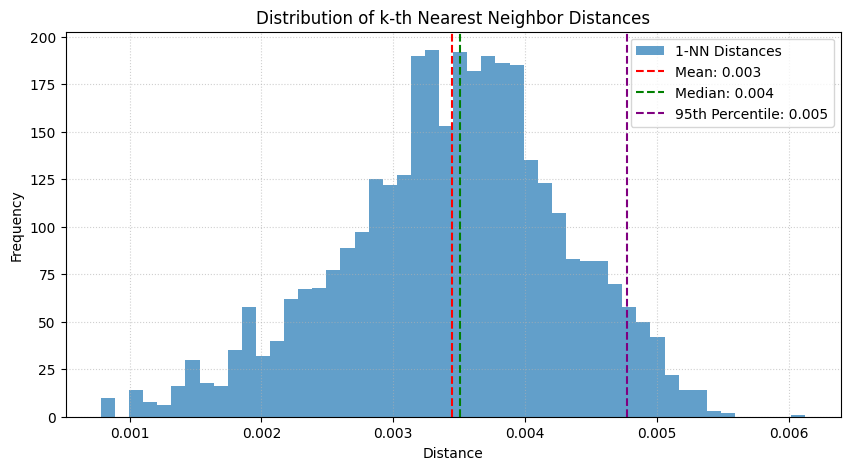

Suggested max_edge_length values:
- mean: 0.0034
- median: 0.0035
- 90th_percentile: 0.0046
- 95th_percentile: 0.0048

PROCESSING dragon 2000 WITH 2000 POINTS


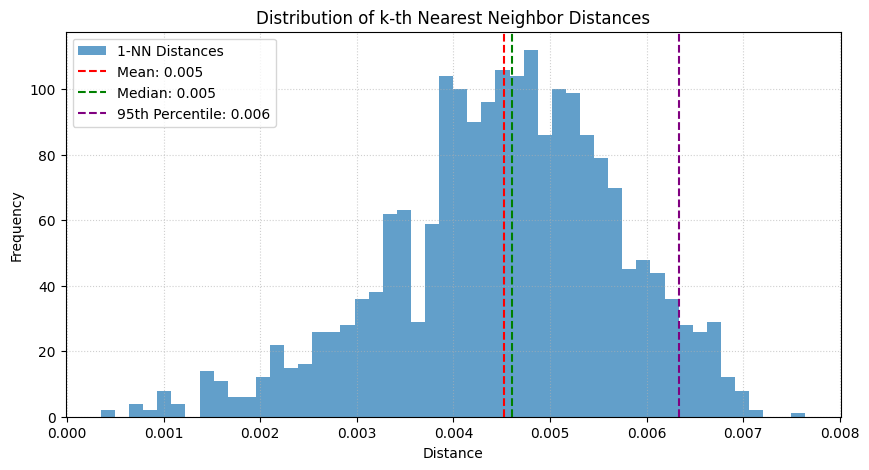

Suggested max_edge_length values:
- mean: 0.0045
- median: 0.0046
- 90th_percentile: 0.0060
- 95th_percentile: 0.0063


In [ ]:
import numpy as np
import pickle
import os
import glob
from plyfile import PlyData
import src.utils as utils

# data = PlyData.read('datasets/dragon_vrip.ply')
# # convert numpy array of vertex 3-tuples to a numpy array of shape (N, 3)
# print(f"Number of vertices in the dataset: {len(data['vertex'].data)}")

# vertices = np.array([list(vertex) for vertex in data['vertex'].data])
# vertices_diameter = np.max(vertices[:, 2]) - np.min(vertices[:, 2])
# print(f"vertex diameter: {vertices_diameter}")
# #save vertices on disk
# np.save('datasets/dragon_vrip_vertices.npy', vertices)

# rng = np.random.default_rng()
# sample_sizes = range(500, 4000 + 500, 500)  # Sample sizes from 500 to 4000 in steps of 500
# # sampled_data = {}

# # # Delete previously created sampled files
# # for file in glob.glob('datasets/dragon_[0-9]*.npy'):
# #     os.remove(file)

# # for size in sample_sizes:
# #     sampled_data[f'sampled_{size}'] = rng.choice(vertices, size, replace=False)
# #     np.save(f'datasets/dragon_{size}.npy', sampled_data[f'sampled_{size}'])

max_dimension = 3  # Maximum dimension for the simplicial complex
complex_res = {}
# for size in sample_sizes:
#     sample = rng.choice(vertices, size, replace=False)
#     # print(f"\nPROCESSING DRAGON {size} WITH {len(sample)} POINTS")
#     max_edge_length = utils.estimate_max_edge_length(sample)
#     complex_res[f"dragon {size}"] = utils.create_complexes(point_cloud=sample, max_edge_length=max_edge_length, max_dimension=max_dimension)

# Load sampled datasets
sampled_datasets = {}
for file in glob.glob('datasets/dragon_ply/sampled_*.ply'):
    data = PlyData.read(file)
    points = np.array([list(vertex) for vertex in data['vertex'].data])
    sample = points[:, :3]  # Use only the first three columns (x, y, z)
    print(f"Number of vertices in the {file} dataset: {len(sample)}")
    sampled_datasets[f"dragon {len(sample)}"] = sample

# import plotly.graph_objects as go

# # Extract sampled_1000 data (first 1000 points)
# sampled_1000 = sampled_datasets['dragon 1000'][:, :3]  # Only use x, y, z coordinates

# # Create 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=sampled_1000[:, 0],
#     y=sampled_1000[:, 1],
#     z=sampled_1000[:, 2],
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=sampled_1000[:, 2],  # Color by z-coordinate
#         colorscale='Viridis',
#         opacity=0.8
#     )
# )])

# fig.update_layout(
#     title='Dragon Dataset - 1000 Sampled Points',
#     scene=dict(
#         xaxis_title='X',
#         yaxis_title='Y',
#         zaxis_title='Z'
#     ),
#     width=800,
#     height=600
# )

# fig.show()

import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

def estimate_max_edge_length(points, k=10):
    """
    Estimates a good max_edge_length using the k-NN distance distribution.
    
    Args:
        points (np.array): A (N, D) array of N points in D dimensions.
        k (int): The number of nearest neighbors to consider.
        
    Returns:
        dict: A dictionary of suggested max_edge_length values.
    """
    if len(points) <= k:
        print("Warning: Number of points is less than or equal to k.")
        return None
        
    # Build a k-d tree for efficient neighbor searches
    tree = cKDTree(points)
    
    # Query the tree for the k-th nearest neighbor of each point.
    # We query for k+1 because the point itself is the 0-th neighbor.
    distances, indices = tree.query(points, k=k+1)
    
    # The distances to the k-th neighbor are in the k-th column
    kth_neighbor_distances = distances[:, k]
    
    # Calculate statistics
    suggestions = {
        'mean': np.mean(kth_neighbor_distances),
        'median': np.median(kth_neighbor_distances),
        '90th_percentile': np.percentile(kth_neighbor_distances, 90),
        '95th_percentile': np.percentile(kth_neighbor_distances, 95)
    }
    
    # --- Visualization (Highly Recommended!) ---
    plt.figure(figsize=(10, 5))
    plt.hist(kth_neighbor_distances, bins=50, alpha=0.7, label=f'{k}-NN Distances')
    plt.axvline(suggestions['mean'], color='red', linestyle='--', label=f"Mean: {suggestions['mean']:.3f}")
    plt.axvline(suggestions['median'], color='green', linestyle='--', label=f"Median: {suggestions['median']:.3f}")
    plt.axvline(suggestions['95th_percentile'], color='purple', linestyle='--', label=f"95th Percentile: {suggestions['95th_percentile']:.3f}")
    plt.title('Distribution of k-th Nearest Neighbor Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    
    return suggestions

# Compute complexes for all loaded datasets
for name, sample in sampled_datasets.items():
    # # Replace this line:
    # # max_edge_length = utils.estimate_max_edge_length(sample)
    # # With this:
    # max_edge_length = utils.estimate_max_edge_length_knn_robust(sample, k=1, percentile=10)
    # print(f"\nPROCESSING {name} WITH {len(sample)} POINTS")
    # print(f"Estimated max edge length: {max_edge_length}")
    # complex_res[name] = utils.create_complexes(point_cloud=sample, max_edge_length=max_edge_length, max_dimension=max_dimension)

    # 2. Get suggestions
    if sample is not None:
        print(f"\nPROCESSING {name} WITH {len(sample)} POINTS")
        suggested_lengths = estimate_max_edge_length(sample, k=1)
        print("Suggested max_edge_length values:")
        for key, value in suggested_lengths.items():
            print(f"- {key}: {value:.4f}")
        
        # 3. Use a suggested value in your Gudhi function
        # For clustered data, the 95th percentile is often a good start.
        max_edge = suggested_lengths['95th_percentile']
        # rips_complex = gudhi.RipsComplex(points=points, max_edge_length=max_edge)
        # ... your complex computation ...
    

# # Create results directory if it doesn't exist
# os.makedirs('results', exist_ok=True)

# # Save complex_res to disk
# with open('results/dragon_complexes.pkl', 'wb') as f:
#     pickle.dump(complex_res, f)
# print(f"\nSaved complexes for {len(complex_res)} samples to 'results/dragon_complexes.pkl'")

Loaded dragon_off/sampled_1501.off: 1501 vertices, 0 faces
Loaded dragon_off/sampled_500.off: 500 vertices, 0 faces
Loaded dragon_off/sampled_4000.off: 3002 vertices, 0 faces
Loaded dragon_off/sampled_1000.off: 1000 vertices, 0 faces
Loaded dragon_off/sampled_2000.off: 2000 vertices, 0 faces
Loaded dragon_off/sampled_3476.off: 3476 vertices, 0 faces

PROCESSING dragon sampled_1501 WITH 1501 POINTS


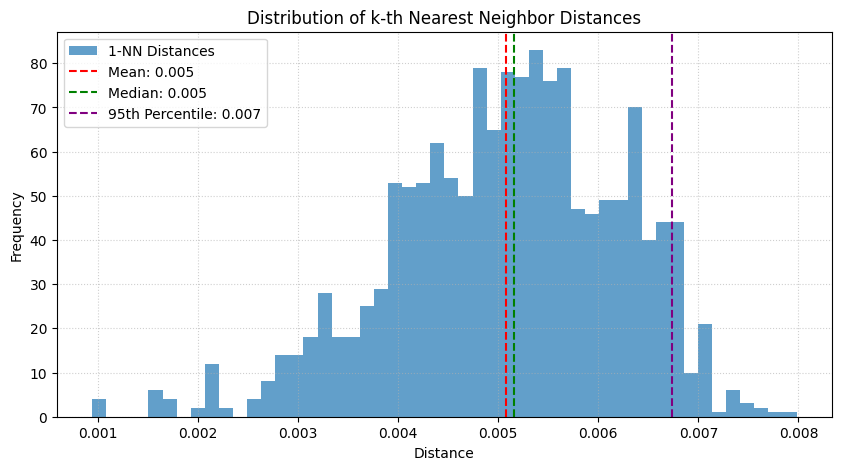

Suggested max_edge_length values:
- mean: 0.0051
- median: 0.0052
- 90th_percentile: 0.0065
- 95th_percentile: 0.0067

PROCESSING dragon sampled_500 WITH 500 POINTS


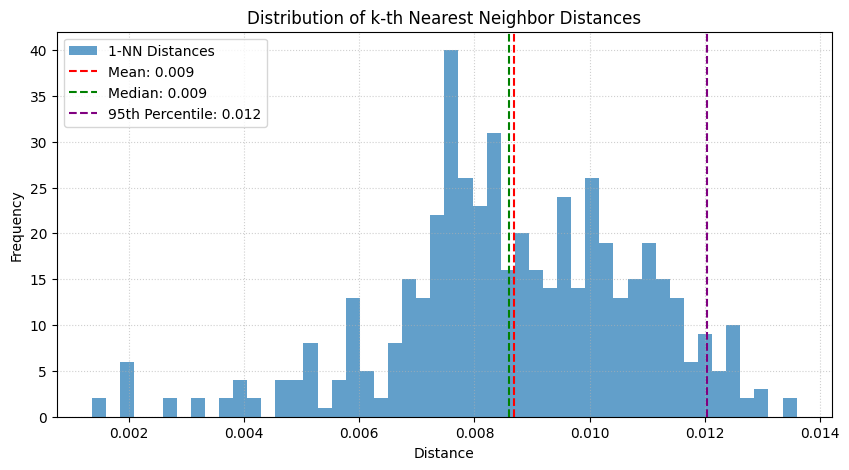

Suggested max_edge_length values:
- mean: 0.0087
- median: 0.0086
- 90th_percentile: 0.0114
- 95th_percentile: 0.0120

PROCESSING dragon sampled_4000 WITH 3002 POINTS


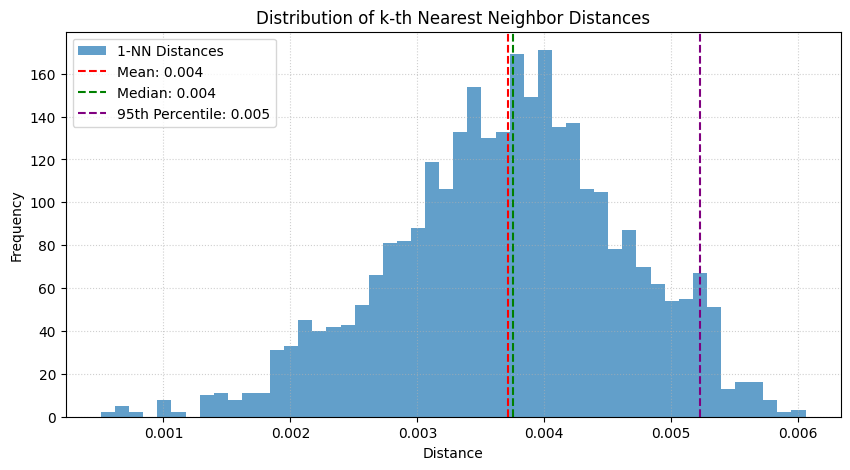

Suggested max_edge_length values:
- mean: 0.0037
- median: 0.0038
- 90th_percentile: 0.0049
- 95th_percentile: 0.0052

PROCESSING dragon sampled_1000 WITH 1000 POINTS


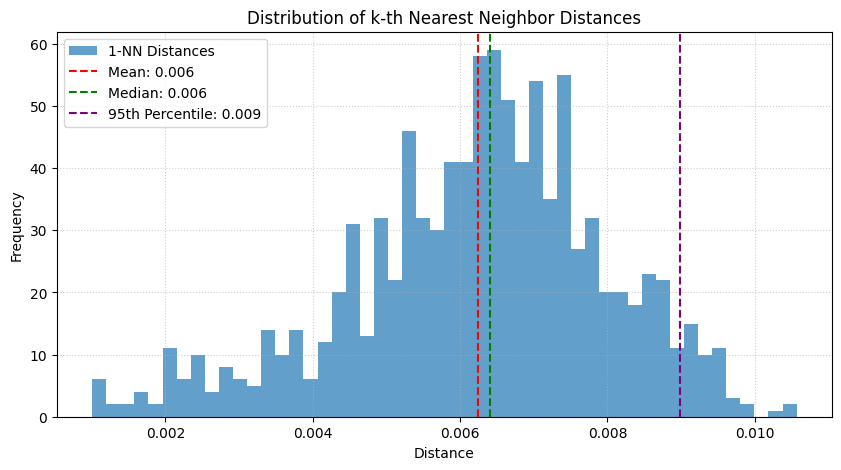

Suggested max_edge_length values:
- mean: 0.0062
- median: 0.0064
- 90th_percentile: 0.0085
- 95th_percentile: 0.0090

PROCESSING dragon sampled_2000 WITH 2000 POINTS


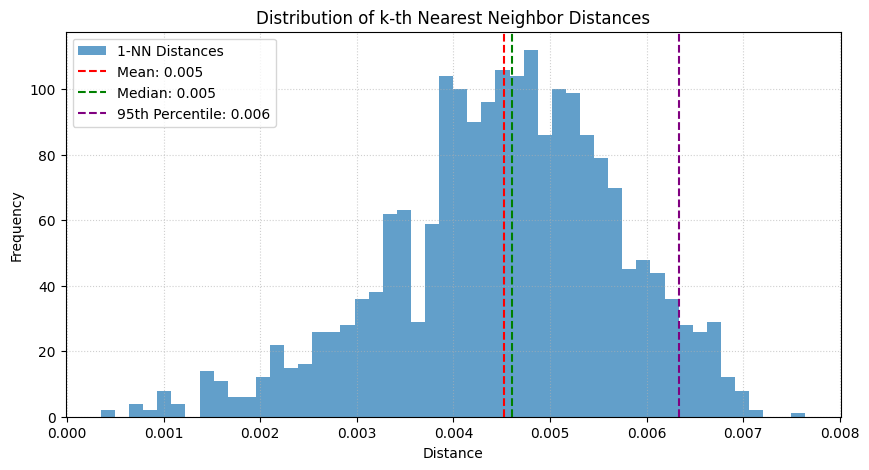

Suggested max_edge_length values:
- mean: 0.0045
- median: 0.0046
- 90th_percentile: 0.0060
- 95th_percentile: 0.0063

PROCESSING dragon sampled_3476 WITH 3476 POINTS


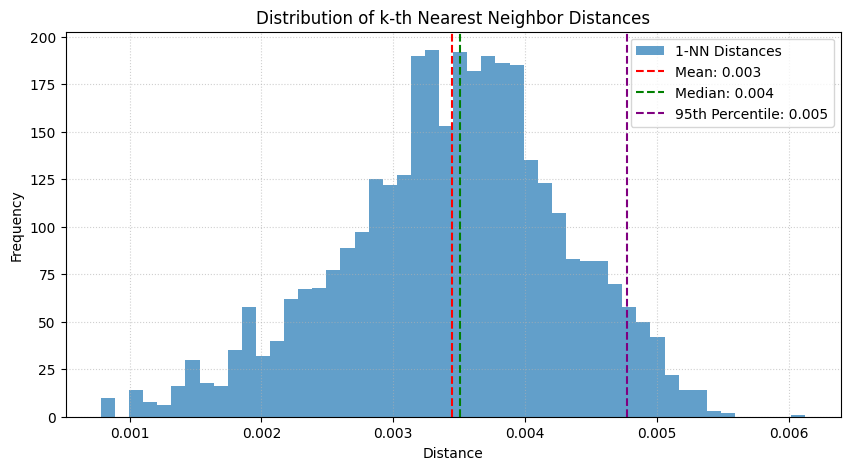

Suggested max_edge_length values:
- mean: 0.0034
- median: 0.0035
- 90th_percentile: 0.0046
- 95th_percentile: 0.0048


In [ ]:
import numpy as np
import os
import glob
import src.utils as utils
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

def read_off_file(filepath):
    """
    Read an OFF file and return vertices and faces.
    
    Args:
        filepath (str): Path to the OFF file
        
    Returns:
        tuple: (vertices, faces) where vertices is (N, 3) array and faces is (M, 3) array
    """
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    # Skip comments and empty lines
    lines = [line.strip() for line in lines if line.strip() and not line.startswith('#')]
    
    # First line should be 'OFF' or 'NOFF'
    if lines[0] not in ['OFF', 'NOFF']:
        raise ValueError(f"File {filepath} is not a valid OFF file (header: {lines[0]})")
    
    # Second line contains number of vertices, faces, and edges
    n_vertices, n_faces, n_edges = map(int, lines[1].split())
    
    # Read vertices
    vertices = []
    for i in range(2, 2 + n_vertices):
        vertex = list(map(float, lines[i].split()[:3]))  # Take only x, y, z coordinates
        vertices.append(vertex)
    
    # Read faces (optional, if you need them)
    faces = []
    for i in range(2 + n_vertices, 2 + n_vertices + n_faces):
        face_data = list(map(int, lines[i].split()))
        if len(face_data) >= 4:  # First number is vertex count, then vertex indices
            face = face_data[1:4]  # Take first 3 vertices for triangular faces
            faces.append(face)
    
    return np.array(vertices), np.array(faces)

sampled_datasets = {}
for file in glob.glob('datasets/dragon_off/*.off'):
    try:
        vertices, faces = read_off_file(file)
        # Extract filename without extension for naming
        filename = os.path.splitext(os.path.basename(file))[0]
        sampled_datasets[f"dragon {filename}"] = vertices
        print(f"Loaded {file}: {len(vertices)} vertices, {len(faces)} faces")
    except Exception as e:
        print(f"Error loading {file}: {e}")

for name, sample in sampled_datasets.items():

    if sample is not None:
        print(f"\nPROCESSING {name} WITH {len(sample)} POINTS")
        suggested_lengths = estimate_max_edge_length(sample, k=1)
        print("Suggested max_edge_length values:")
        for key, value in suggested_lengths.items():
            print(f"- {key}: {value:.4f}")
        
        max_edge = suggested_lengths['95th_percentile']

Loading PLY file...
PLY file: 500 vertices, 6 dimensions
PLY file (xyz only): 500 vertices, 3 dimensions
Loading OFF file...
OFF file: 500 vertices, 3 dimensions, 0 faces

=== COMPARISON ===
Number of vertices - PLY: 500, OFF: 500
Vertices match in count: True
Vertices are approximately equal: False
Maximum difference between vertices: 7.4329376265058755e-09

PLY coordinate ranges (xyz only):
  X: [-0.107973, 0.096427]
  Y: [0.052782, 0.197095]
  Z: [-0.050365, 0.041150]

OFF coordinate ranges:
  X: [-0.107973, 0.096427]
  Y: [0.052782, 0.197095]
  Z: [-0.050365, 0.041149]

Statistics of point-wise differences:
  Mean distance: 0.000000
  Max distance: 0.000000
  Std distance: 0.000000


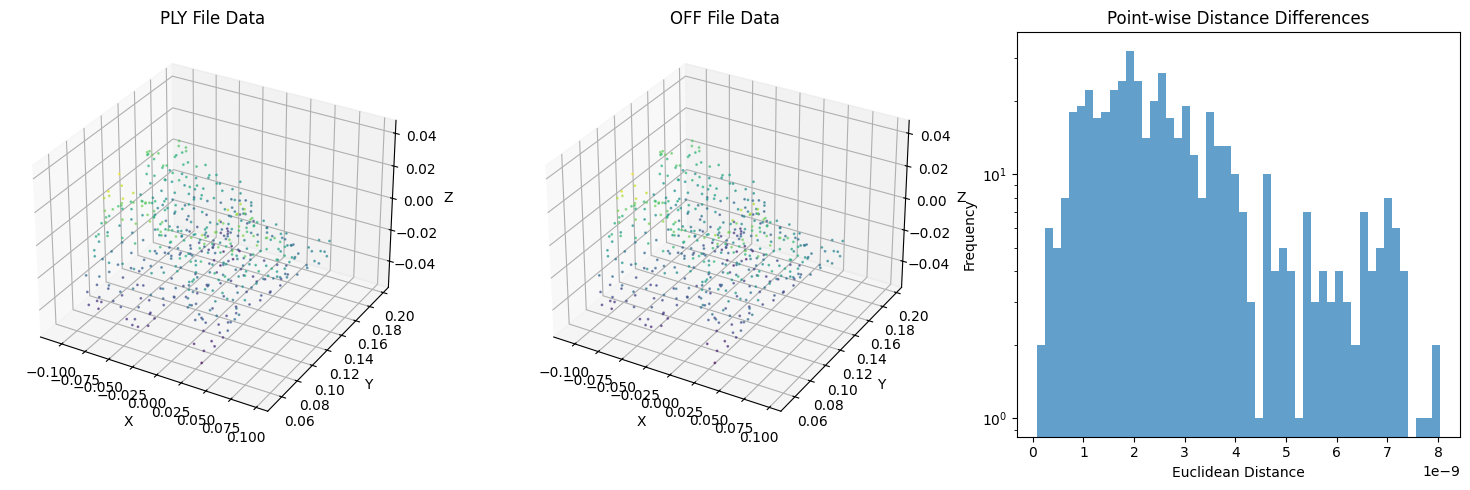


First 5 vertices comparison:
PLY vertices (xyz only):
[[ 0.096427    0.136725   -0.00854977]
 [-0.047073    0.0719935   0.0322625 ]
 [-0.0961796   0.144075    0.0203625 ]
 [-0.061423    0.0743903   0.0228125 ]
 [-0.046723    0.085625    0.0209982 ]]
OFF vertices:
[[ 0.096427    0.136725   -0.00854977]
 [-0.047073    0.0719935   0.0322625 ]
 [-0.0961796   0.144075    0.0203625 ]
 [-0.061423    0.0743903   0.0228125 ]
 [-0.046723    0.085625    0.0209982 ]]


In [ ]:
import numpy as np
from plyfile import PlyData
import matplotlib.pyplot as plt

# Function to read OFF files (already defined in your code)
def read_off_file(filepath):
    """
    Read an OFF file and return vertices and faces.
    
    Args:
        filepath (str): Path to the OFF file
        
    Returns:
        tuple: (vertices, faces) where vertices is (N, 3) array and faces is (M, 3) array
    """
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    # Skip comments and empty lines
    lines = [line.strip() for line in lines if line.strip() and not line.startswith('#')]
    
    # First line should be 'OFF' or 'NOFF'
    if lines[0] not in ['OFF', 'NOFF']:
        raise ValueError(f"File {filepath} is not a valid OFF file (header: {lines[0]})")
    
    # Second line contains number of vertices, faces, and edges
    n_vertices, n_faces, n_edges = map(int, lines[1].split())
    
    # Read vertices
    vertices = []
    for i in range(2, 2 + n_vertices):
        vertex = list(map(float, lines[i].split()[:3]))  # Take only x, y, z coordinates
        vertices.append(vertex)
    
    # Read faces (optional, if you need them)
    faces = []
    for i in range(2 + n_vertices, 2 + n_vertices + n_faces):
        face_data = list(map(int, lines[i].split()))
        if len(face_data) >= 4:  # First number is vertex count, then vertex indices
            face = face_data[1:4]  # Take first 3 vertices for triangular faces
            faces.append(face)
    
    return np.array(vertices), np.array(faces)

# Load PLY file
print("Loading PLY file...")
ply_data = PlyData.read('datasets/dragon_ply/sampled_500.ply')
ply_vertices = np.array([list(vertex) for vertex in ply_data['vertex'].data])
print(f"PLY file: {ply_vertices.shape[0]} vertices, {ply_vertices.shape[1]} dimensions")

# Extract only x, y, z coordinates from PLY (first 3 columns)
ply_vertices_xyz = ply_vertices[:, :3]
print(f"PLY file (xyz only): {ply_vertices_xyz.shape[0]} vertices, {ply_vertices_xyz.shape[1]} dimensions")

# Load OFF file
print("Loading OFF file...")
off_vertices, off_faces = read_off_file('datasets/dragon_off/sampled_500.off')
print(f"OFF file: {off_vertices.shape[0]} vertices, {off_vertices.shape[1]} dimensions, {off_faces.shape[0]} faces")

# Compare basic statistics
print("\n=== COMPARISON ===")
print(f"Number of vertices - PLY: {len(ply_vertices)}, OFF: {len(off_vertices)}")
print(f"Vertices match in count: {len(ply_vertices) == len(off_vertices)}")

# Check if vertices are the same (allowing for small floating point differences)
if len(ply_vertices_xyz) == len(off_vertices):
    # Ensure both arrays are float64 and have the same shape
    ply_xyz_clean = ply_vertices_xyz.astype(np.float64)
    off_clean = off_vertices.astype(np.float64)
    
    # Sort both arrays to compare them properly
    ply_sorted = ply_xyz_clean[np.lexsort((ply_xyz_clean[:, 2], ply_xyz_clean[:, 1], ply_xyz_clean[:, 0]))]
    off_sorted = off_clean[np.lexsort((off_clean[:, 2], off_clean[:, 1], off_clean[:, 0]))]
    
    vertices_close = np.allclose(ply_sorted, off_sorted, rtol=1e-10, atol=1e-10)
    print(f"Vertices are approximately equal: {vertices_close}")
    
    if not vertices_close:
        diff = np.abs(ply_sorted - off_sorted)
        max_diff = np.max(diff)
        print(f"Maximum difference between vertices: {max_diff}")

# Compare coordinate ranges
print(f"\nPLY coordinate ranges (xyz only):")
print(f"  X: [{np.min(ply_vertices_xyz[:, 0]):.6f}, {np.max(ply_vertices_xyz[:, 0]):.6f}]")
print(f"  Y: [{np.min(ply_vertices_xyz[:, 1]):.6f}, {np.max(ply_vertices_xyz[:, 1]):.6f}]")
print(f"  Z: [{np.min(ply_vertices_xyz[:, 2]):.6f}, {np.max(ply_vertices_xyz[:, 2]):.6f}]")

print(f"\nOFF coordinate ranges:")
print(f"  X: [{np.min(off_vertices[:, 0]):.6f}, {np.max(off_vertices[:, 0]):.6f}]")
print(f"  Y: [{np.min(off_vertices[:, 1]):.6f}, {np.max(off_vertices[:, 1]):.6f}]")
print(f"  Z: [{np.min(off_vertices[:, 2]):.6f}, {np.max(off_vertices[:, 2]):.6f}]")

# Visualize both datasets
fig = plt.figure(figsize=(15, 5))

# PLY data
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(ply_vertices_xyz[:, 0], ply_vertices_xyz[:, 1], ply_vertices_xyz[:, 2], 
           c=ply_vertices_xyz[:, 2], cmap='viridis', alpha=0.6, s=1)
ax1.set_title('PLY File Data')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# OFF data
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(off_vertices[:, 0], off_vertices[:, 1], off_vertices[:, 2], 
           c=off_vertices[:, 2], cmap='viridis', alpha=0.6, s=1)
ax2.set_title('OFF File Data')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Difference visualization (if vertices count matches)
if len(ply_vertices_xyz) == len(off_vertices):
    ax3 = fig.add_subplot(133)
    # Calculate point-wise differences using xyz coordinates only
    diff_norms = np.linalg.norm(ply_vertices_xyz - off_vertices, axis=1)
    ax3.hist(diff_norms, bins=50, alpha=0.7)
    ax3.set_title('Point-wise Distance Differences')
    ax3.set_xlabel('Euclidean Distance')
    ax3.set_ylabel('Frequency')
    ax3.set_yscale('log')
    print(f"\nStatistics of point-wise differences:")
    print(f"  Mean distance: {np.mean(diff_norms):.6f}")
    print(f"  Max distance: {np.max(diff_norms):.6f}")
    print(f"  Std distance: {np.std(diff_norms):.6f}")

plt.tight_layout()
plt.show()

# Check first few vertices for detailed comparison
print(f"\nFirst 5 vertices comparison:")
print("PLY vertices (xyz only):")
print(ply_vertices_xyz[:5])
print("OFF vertices:")
print(off_vertices[:5])


Loading PLY file: datasets/sampled_500.ply
Loaded 500 vertices
Calculating pairwise distances...
Mean of minimum distances: 0.008684
Standard deviation: 0.002190
Min value: 0.001362
Max value: 0.013595


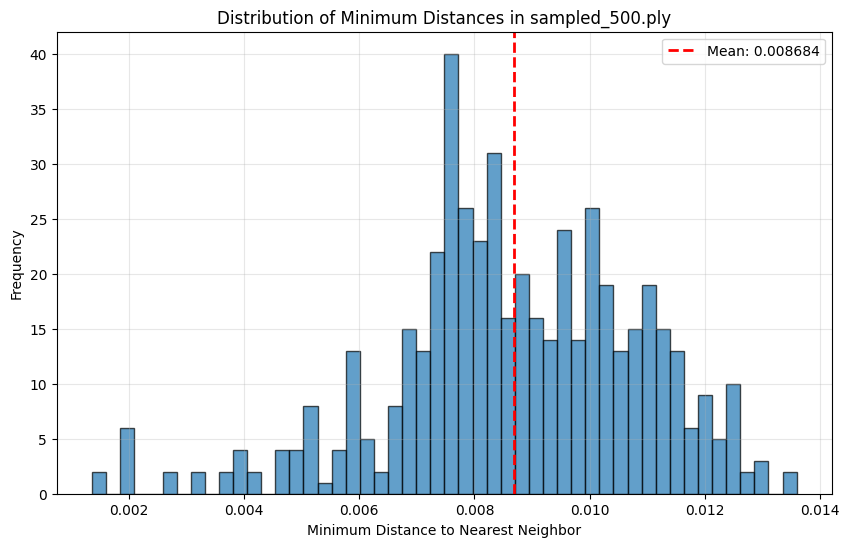


Final result: Mean minimum distance = 0.008684


In [ ]:
import numpy as np
from plyfile import PlyData
from scipy.spatial.distance import cdist

def calculate_mean_min_distance(ply_file_path):
    """
    Calculate the mean of minimum distances between points in a PLY file.
    
    Args:
        ply_file_path (str): Path to the PLY file
        
    Returns:
        float: Mean of minimum distances
    """
    # Load PLY file
    print(f"Loading PLY file: {ply_file_path}")
    ply_data = PlyData.read(ply_file_path)
    
    # Extract vertices (x, y, z coordinates)
    vertices = np.array([list(vertex) for vertex in ply_data['vertex'].data])
    print(f"Loaded {len(vertices)} vertices")
    
    # Use only x, y, z coordinates (first 3 columns)
    points = vertices[:, :3]
    
    # Calculate pairwise distances between all points
    print("Calculating pairwise distances...")
    distances = cdist(points, points, metric='euclidean')
    
    # Set diagonal to infinity to exclude self-distances (distance from point to itself)
    np.fill_diagonal(distances, np.inf)
    
    # Find minimum distance for each point to all other points
    min_distances = np.min(distances, axis=1)
    
    # Calculate mean of minimum distances
    mean_min_distance = np.mean(min_distances)
    
    print(f"Mean of minimum distances: {mean_min_distance:.6f}")
    print(f"Standard deviation: {np.std(min_distances):.6f}")
    print(f"Min value: {np.min(min_distances):.6f}")
    print(f"Max value: {np.max(min_distances):.6f}")
    
    return mean_min_distance, min_distances

# Calculate for sampled_500.ply
mean_distance, all_min_distances = calculate_mean_min_distance('datasets/sampled_500.ply')

# Optional: Visualize the distribution of minimum distances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(all_min_distances, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(mean_distance, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_distance:.6f}')
plt.xlabel('Minimum Distance to Nearest Neighbor')
plt.ylabel('Frequency')
plt.title('Distribution of Minimum Distances in sampled_500.ply')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal result: Mean minimum distance = {mean_distance:.6f}")

Loading OFF file: dragon_off/sampled_500.off
Loaded 500 vertices, 0 faces
Calculating pairwise distances...
Mean of minimum distances: 0.008684
Standard deviation: 0.002190
Min value: 0.001362
Max value: 0.013595


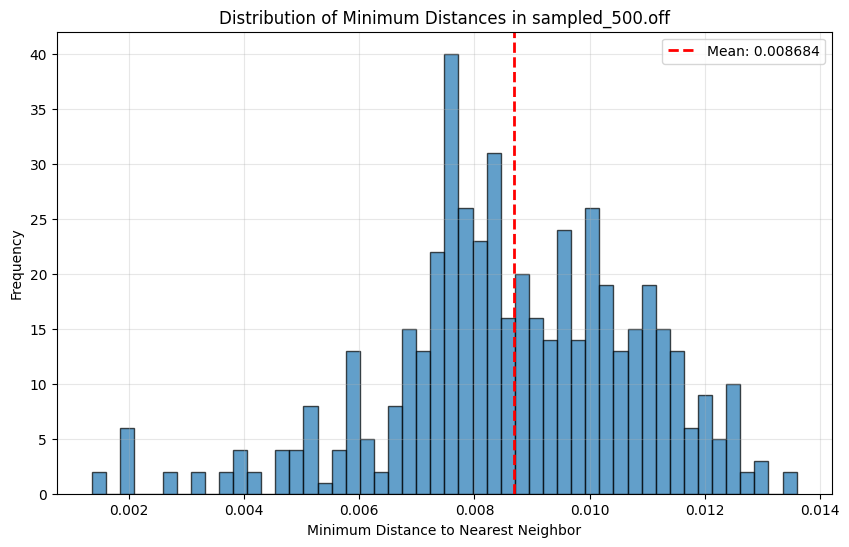


Final result: Mean minimum distance = 0.008684


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def calculate_mean_min_distance_off(off_file_path):
    """
    Calculate the mean of minimum distances between points in an OFF file.
    
    Args:
        off_file_path (str): Path to the OFF file
        
    Returns:
        tuple: (mean_min_distance, min_distances)
    """
    # Load OFF file using the existing function
    print(f"Loading OFF file: {off_file_path}")
    vertices, faces = read_off_file(off_file_path)
    print(f"Loaded {len(vertices)} vertices, {len(faces)} faces")
    
    # Vertices are already x, y, z coordinates
    points = vertices
    
    # Calculate pairwise distances between all points
    print("Calculating pairwise distances...")
    distances = cdist(points, points, metric='euclidean')
    
    # Set diagonal to infinity to exclude self-distances (distance from point to itself)
    np.fill_diagonal(distances, np.inf)
    
    # Find minimum distance for each point to all other points
    min_distances = np.min(distances, axis=1)
    
    # Calculate mean of minimum distances
    mean_min_distance = np.mean(min_distances)
    
    print(f"Mean of minimum distances: {mean_min_distance:.6f}")
    print(f"Standard deviation: {np.std(min_distances):.6f}")
    print(f"Min value: {np.min(min_distances):.6f}")
    print(f"Max value: {np.max(min_distances):.6f}")
    
    return mean_min_distance, min_distances

# Calculate for sampled_500.off
mean_distance_off, all_min_distances_off = calculate_mean_min_distance_off('dragon_off/sampled_500.off')

# Optional: Visualize the distribution of minimum distances
plt.figure(figsize=(10, 6))
plt.hist(all_min_distances_off, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(mean_distance_off, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_distance_off:.6f}')
plt.xlabel('Minimum Distance to Nearest Neighbor')
plt.ylabel('Frequency')
plt.title('Distribution of Minimum Distances in sampled_500.off')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal result: Mean minimum distance = {mean_distance_off:.6f}")